In [ ]:
import os
import sys

for p in ["/opt/homebrew/bin", "/usr/local/bin"]:
    if p not in os.environ.get("PATH", ""):
        os.environ["PATH"] = p + ":" + os.environ.get("PATH", "")

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import xgboost as xgb

In [ ]:
mdb_file = r'/Users/mattjarvis/Downloads/avall.mdb'

def read_mdb_table(mdb_path, table_name):
    cmd = ["mdb-export", mdb_path, table_name]
    result = subprocess.run(cmd, capture_output=True, text=True)
    return pd.read_csv(StringIO(result.stdout))


In [ ]:
events = read_mdb_table(mdb_file, 'events')
events_seq = read_mdb_table(mdb_file, 'Events_Sequence')
findings = read_mdb_table(mdb_file, 'Findings')
aircraft = read_mdb_table(mdb_file, 'aircraft')
events_sq_codes = read_mdb_table(mdb_file, 'ct_seqevt')

print("Data loaded.")


/var/folders/l9/gx56nvf53ls71h5jmyflcct80000gn/T/ipykernel_9236/1977795416.py:10: DtypeWarning: Columns (0,10,31,51) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(StringIO(result.stdout))
/var/folders/l9/gx56nvf53ls71h5jmyflcct80000gn/T/ipykernel_9236/1977795416.py:10: DtypeWarning: Columns (0,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(StringIO(result.stdout))


Data loaded.


/var/folders/l9/gx56nvf53ls71h5jmyflcct80000gn/T/ipykernel_9236/1977795416.py:10: DtypeWarning: Columns (0,59) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(StringIO(result.stdout))


In [ ]:

events_seq = events_seq.sort_values(
    ['ev_id','Aircraft_Key','Occurrence_No']
).reset_index(drop=True)

valid_classes = ["NONE", "MINR", "SERS", "FATL"]
events_clean = events.dropna(subset=["ev_highest_injury"])
events_clean = events_clean[
    events_clean["ev_highest_injury"].isin(valid_classes)
]

print("Preprocessing complete.")


Preprocessing complete.


In [8]:
incidents = events_seq.sort_values(by = ['ev_id', 'Aircraft_Key','Occurrence_No']).reset_index(drop = True)
incidents = incidents.merge(events, on = 'ev_id', how = 'left')

incidents = incidents[incidents['ev_date'].isna()==False].reset_index(drop = True)
incidents['ev_hour'] = pd.to_datetime(incidents['ev_date'], format='%m/%d/%y %H:%M:%S').dt.hour
incidents['ev_month'] = pd.to_datetime(incidents['ev_date'], format='%m/%d/%y %H:%M:%S').dt.month

def clean_ntsb_datetime(df):
    df['ev_date'] = pd.to_datetime(df['ev_date'], errors='coerce')
    df['time_str'] = df['ev_time'].fillna(0).astype(int).astype(str).str.zfill(4)
    df['full_timestamp'] = pd.to_datetime(
        df['ev_date'].astype(str) + ' ' + 
        df['time_str'].str[:2] + ':' + df['time_str'].str[2:], 
        errors='coerce'
    )
    return df

incidents = clean_ntsb_datetime(incidents)
incidents['time_delta'] = incidents.groupby(['ev_id', 'Aircraft_Key'])['full_timestamp'].diff()
incidents['delta_minutes'] = incidents['time_delta'].dt.total_seconds() / 60
incidents['delta_minutes'] = incidents['delta_minutes'].fillna(0)

gaps_exist = incidents[incidents['delta_minutes'] > 0]

total_seqs = incidents['ev_id'].nunique()
zero_gap_seqs = incidents.groupby('ev_id')['delta_minutes'].sum().eq(0).sum()
print('Incidents with 0.0 total time elapsed: '+str(zero_gap_seqs))
print('Incidents total: '+str(total_seqs))

/var/folders/l9/gx56nvf53ls71h5jmyflcct80000gn/T/ipykernel_9236/2310475974.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ev_date'] = pd.to_datetime(df['ev_date'], errors='coerce')


Incidents with 0.0 total time elapsed: 23950
Incidents total: 23950


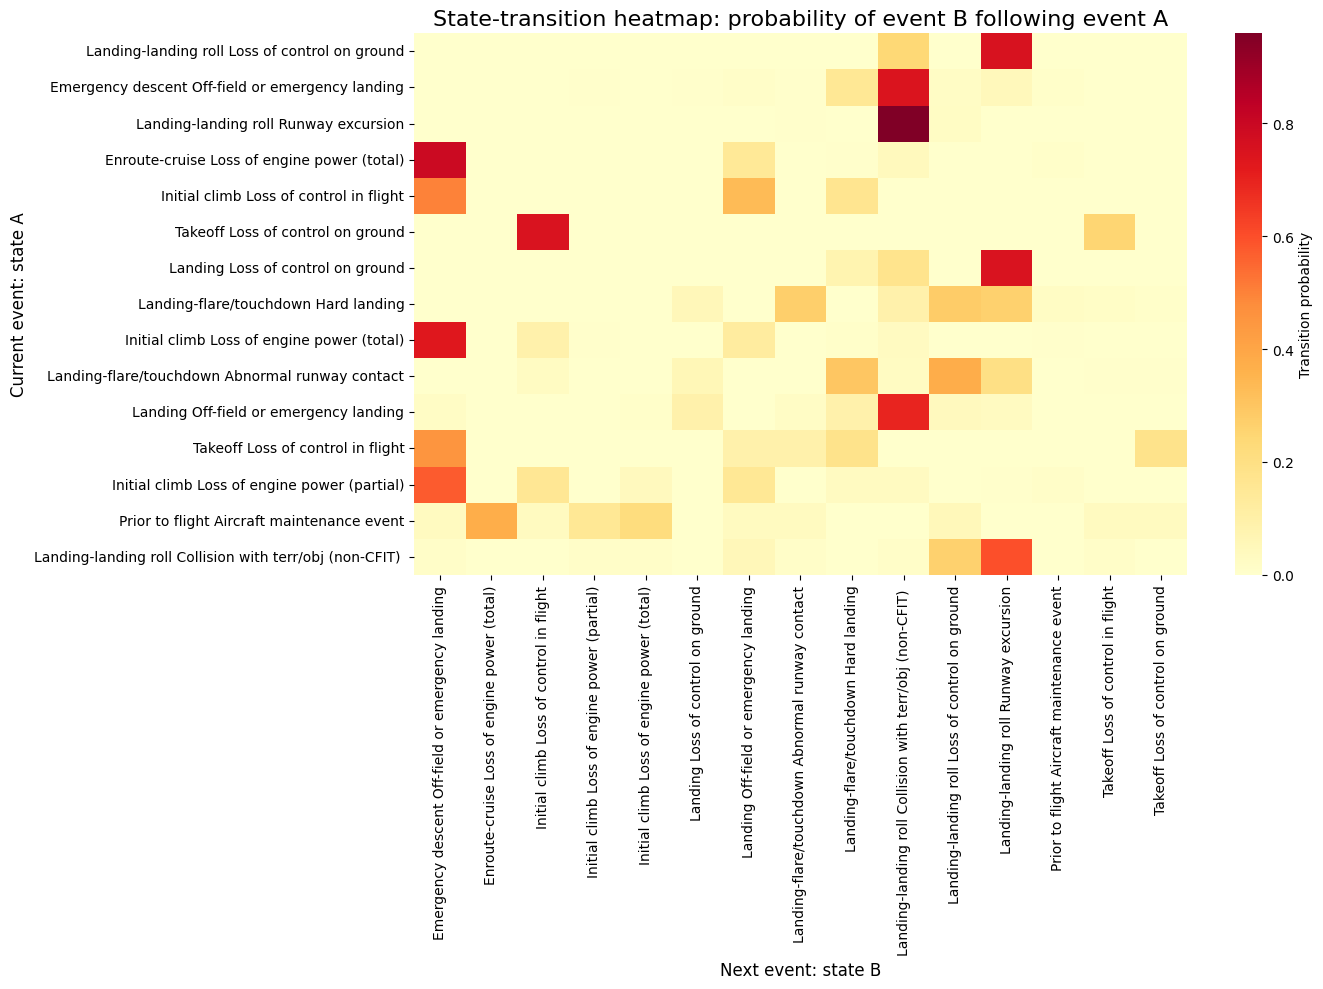

In [6]:
#EDA 1, transition matrix

incidents['next_occurrence'] = incidents.groupby(['ev_id', 'Aircraft_Key'])['Occurrence_Description'].shift(-1)

transitions = incidents[['Occurrence_Description', 'next_occurrence']].dropna()

transitions.columns = ['From_Event', 'To_Event']

import seaborn as sns
import matplotlib.pyplot as plt

matrix = pd.crosstab(transitions['From_Event'], transitions['To_Event'])

# take top 15 most frequent events
top_events = transitions['From_Event'].value_counts().nlargest(15).index
matrix_filtered = matrix.loc[top_events, matrix.columns.isin(top_events)]

# normalise matrix, turns counts into the probability of next state
matrix_norm = matrix_filtered.div(matrix_filtered.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(matrix_norm, cmap='YlOrRd', fmt='.2f', cbar_kws={'label': 'Transition probability'})

plt.title('State-transition heatmap: probability of event B following event A', fontsize=16)
plt.xlabel('Next event: state B', fontsize=12)
plt.ylabel('Current event: state A', fontsize=12)

plt.tight_layout()
plt.show()

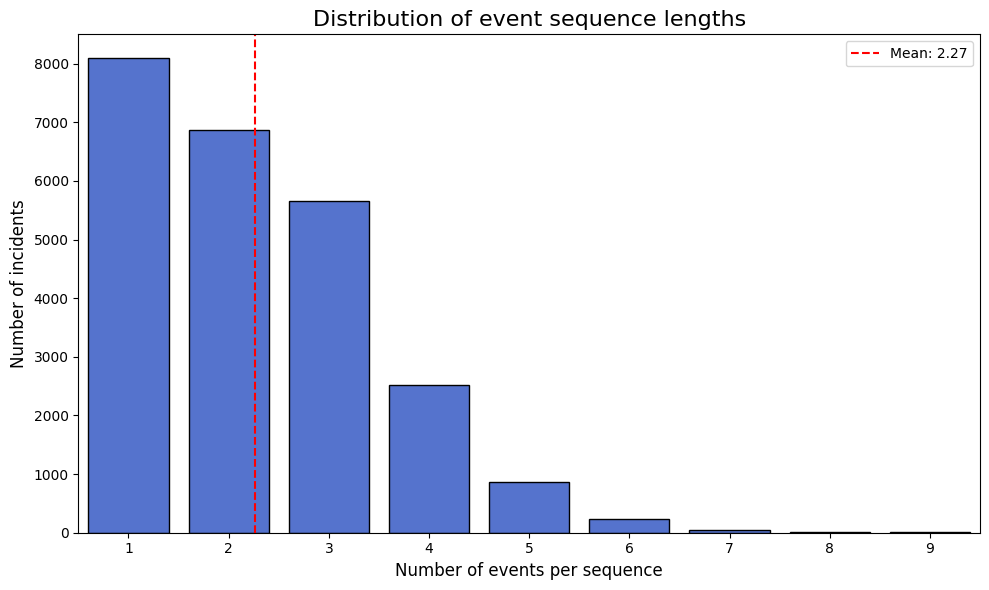

In [7]:
#EDA 2 - distribution of event sequence lengths (number of event sequence steps)

sequence_lengths = incidents.groupby(['ev_id', 'Aircraft_Key'])['Occurrence_No'].count().reset_index()
sequence_lengths.columns = ['ev_id', 'Aircraft_Key', 'seq_length']

plt.figure(figsize=(10, 6))
sns.countplot(data=sequence_lengths, x='seq_length', color='royalblue', edgecolor='black')

plt.title('Distribution of event sequence lengths', fontsize=16)
plt.xlabel('Number of events per sequence', fontsize=12)
plt.ylabel('Number of incidents', fontsize=12)

mean_val = sequence_lengths['seq_length'].mean()
plt.axvline(mean_val - 1, color='red', linestyle='--', label='Mean: '+str(round(mean_val,2)))
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_96818/3782028973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=first_events, x='month', palette='Blues', ax=ax1, edgecolor='black')


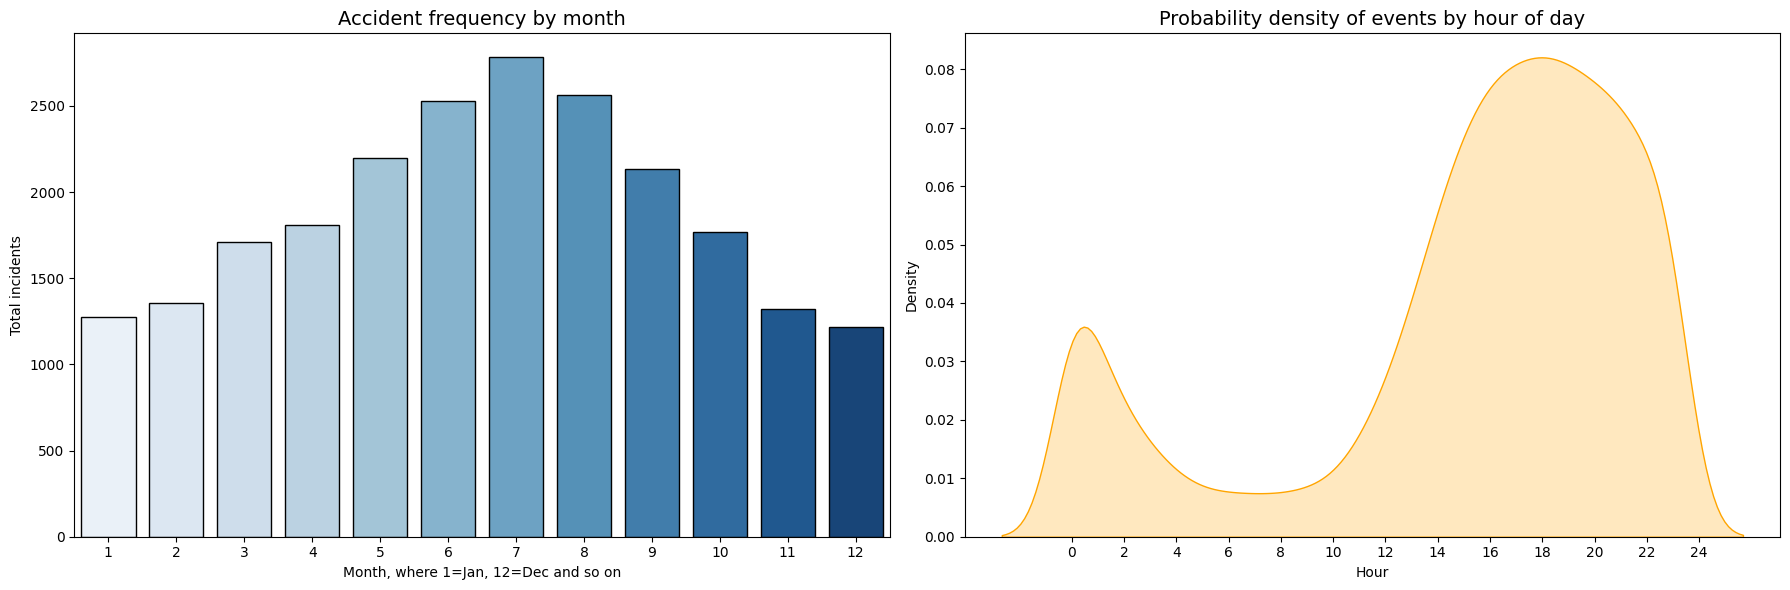

In [8]:
#EDA 3 - accident frequency by month and by hour of the day

first_events = incidents[incidents['Occurrence_No'] == 1].copy()

first_events['month'] = first_events['full_timestamp'].dt.month
first_events['hour'] = first_events['full_timestamp'].dt.hour

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# plot 1, months
sns.countplot(data=first_events, x='month', palette='Blues', ax=ax1, edgecolor='black')
ax1.set_title('Accident frequency by month', fontsize=14)
ax1.set_xlabel('Month, where 1=Jan, 12=Dec and so on')
ax1.set_ylabel('Total incidents')

# plot 2, hours 
sns.kdeplot(data=first_events, x='hour', fill=True, color='orange', ax=ax2)
ax2.set_title('Probability density of events by hour of day', fontsize=14)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Density')
ax2.set_xticks(range(0, 25, 2))

plt.tight_layout()
plt.show()

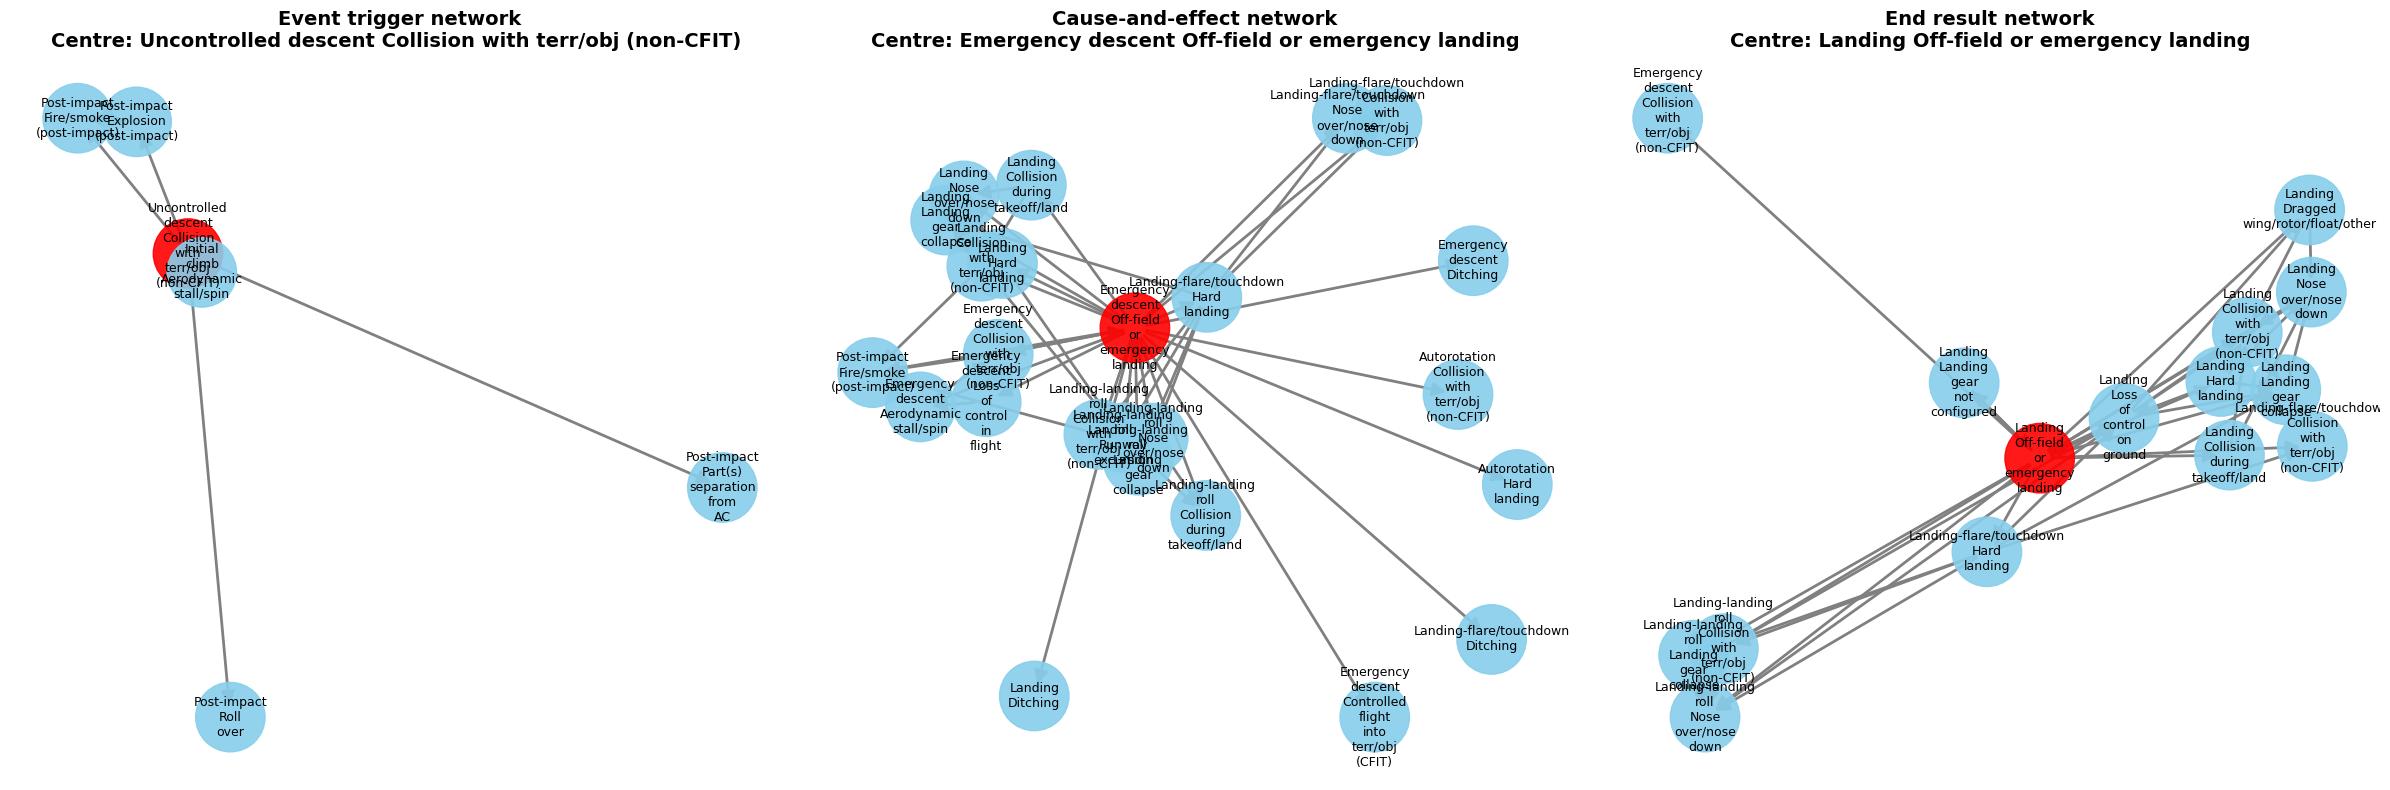

In [9]:
import networkx as nx

# EDA 4 - important community analysis 

edge_counts = transitions.groupby(['From_Event', 'To_Event']).size().reset_index(name='weight')
significant_edges = edge_counts[edge_counts['weight'] > 5]

G = nx.from_pandas_edgelist(significant_edges, 
                            source='From_Event', 
                            target='To_Event', 
                            edge_attr='weight', 
                            create_using=nx.DiGraph())


# identify most important nodes to use as centres in our graph
centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# get partitions
centers = [top_nodes[0][0], top_nodes[1][0], top_nodes[2][0]]
titles = ["Event trigger network", "Cause-and-effect network", "End result network"]

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for i, center_node in enumerate(centers):
    # gets centre node and immediate neighbours
    ego = nx.ego_graph(G, center_node, radius=1)
    
    pos = nx.spring_layout(ego, k=0.8, seed=42)
    ax = axes[i]

    node_colors = ['red' if n == center_node else 'skyblue' for n in ego.nodes()]
    
    nx.draw_networkx_nodes(ego, pos, node_size=2500, node_color=node_colors, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(ego, pos, width=2, edge_color='gray', arrowsize=20, ax=ax)
    
    labels = {n: n.replace(' ', '\n') for n in ego.nodes()}
    nx.draw_networkx_labels(ego, pos, labels=labels, font_size=9, ax=ax)
    
    ax.set_title(f"{titles[i]}\nCentre: {center_node}", fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

/var/folders/88/62x1m0kj32q1kjshp1jjv34c0000gn/T/ipykernel_96818/3623976338.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(make_counts['Make'], rotation=45, ha='right')


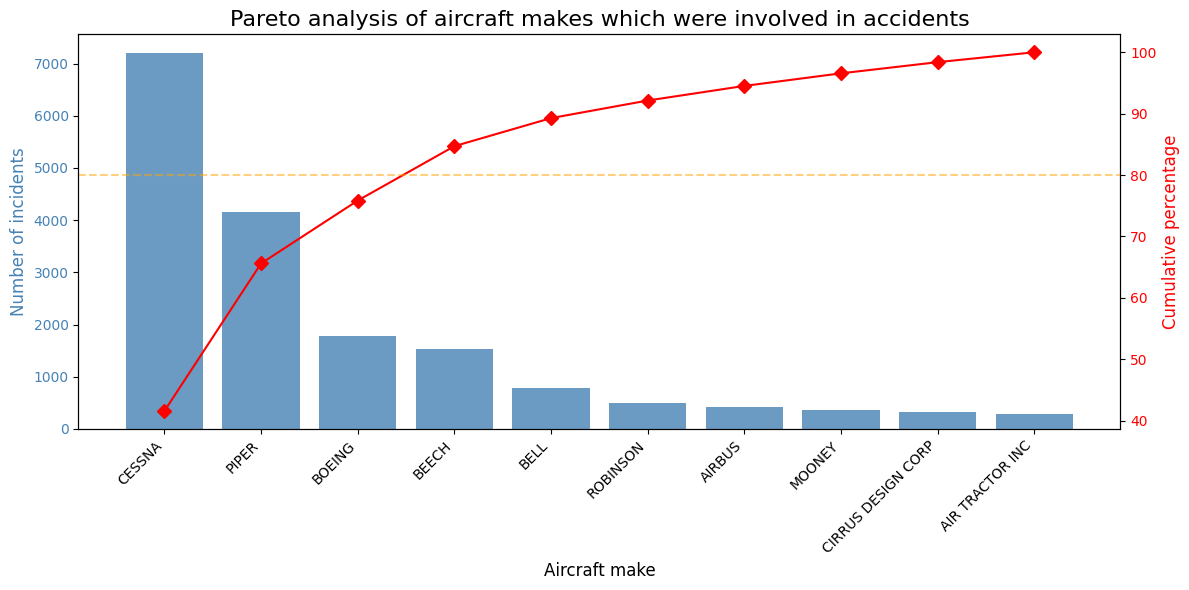

In [10]:
#EDA 5 - Pareto analysis of aircraft make in accidents 
# note: Pareto analysis tries to see the 80/20 rule in practice - i.e. are 20% of planes, say from one brand, causing 80% of accidents?

aircraft['acft_make_clean'] = aircraft['acft_make'].str.upper().str.strip()
make_counts = aircraft['acft_make_clean'].value_counts().head(10).reset_index()
make_counts.columns = ['Make', 'Count']

make_counts['cum_percentage'] = make_counts['Count'].cumsum() / make_counts['Count'].sum() * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(make_counts['Make'], make_counts['Count'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Aircraft make', fontsize=12)
ax1.set_ylabel('Number of incidents', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(make_counts['Make'], make_counts['cum_percentage'], color='red', marker='D', ms=7, label='Cumulative %')
ax2.axhline(80, color='orange', linestyle='--', alpha=0.5) #threshold
ax2.set_ylabel('Cumulative percentage', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Pareto analysis of aircraft makes which were involved in accidents', fontsize=16)
ax1.set_xticklabels(make_counts['Make'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

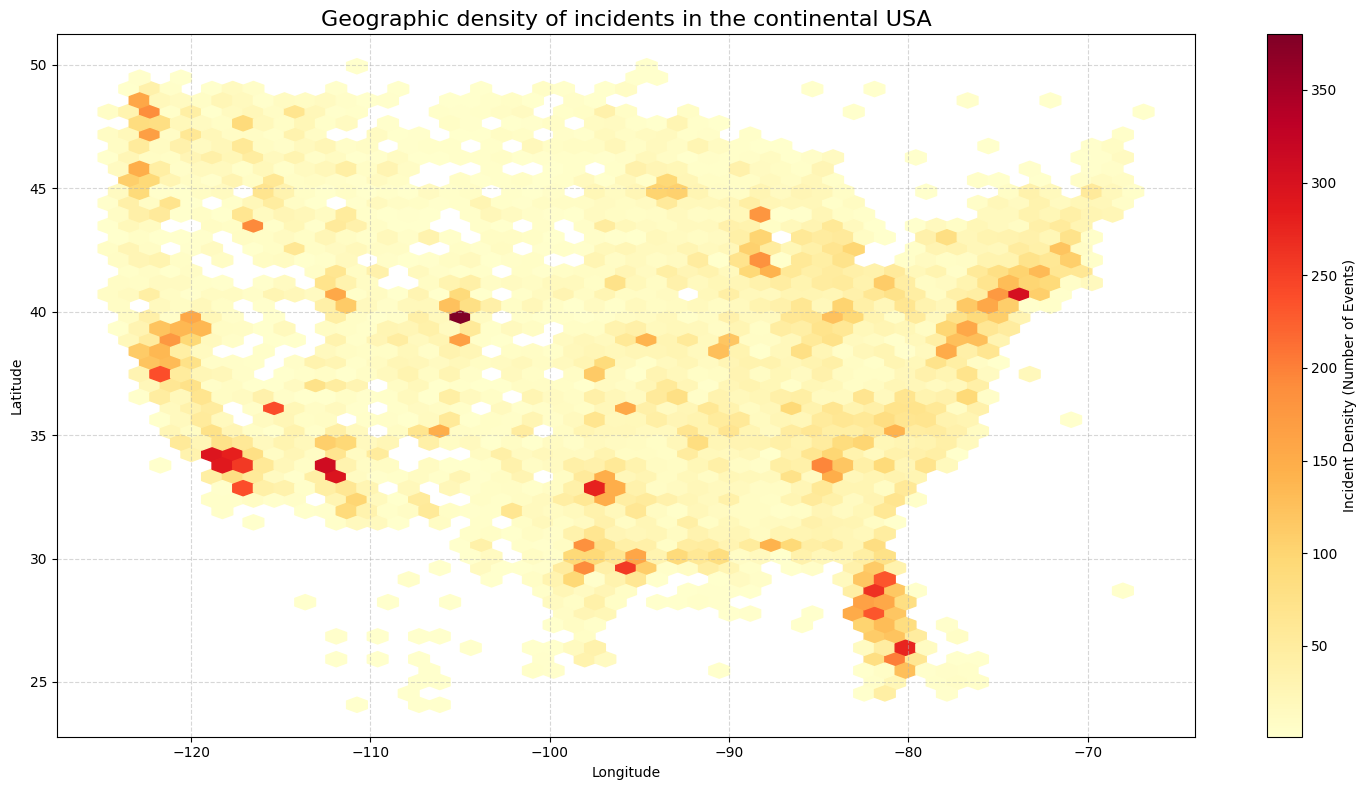

In [11]:
#EDA 6 - geographic distribution of accidents, continental USA

geo_data = incidents.dropna(subset=['dec_latitude', 'dec_longitude'])
geo_data = geo_data[(geo_data['dec_latitude'] > 24) & (geo_data['dec_latitude'] < 50) & 
                    (geo_data['dec_longitude'] > -125) & (geo_data['dec_longitude'] < -66)]

plt.figure(figsize=(15, 8))

hb = plt.hexbin(geo_data['dec_longitude'], geo_data['dec_latitude'], 
                gridsize=50, cmap='YlOrRd', mincnt=1)

cb = plt.colorbar(hb, ax=plt.gca())
cb.set_label('Incident Density (Number of Events)')

plt.title('Geographic density of incidents in the continental USA', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

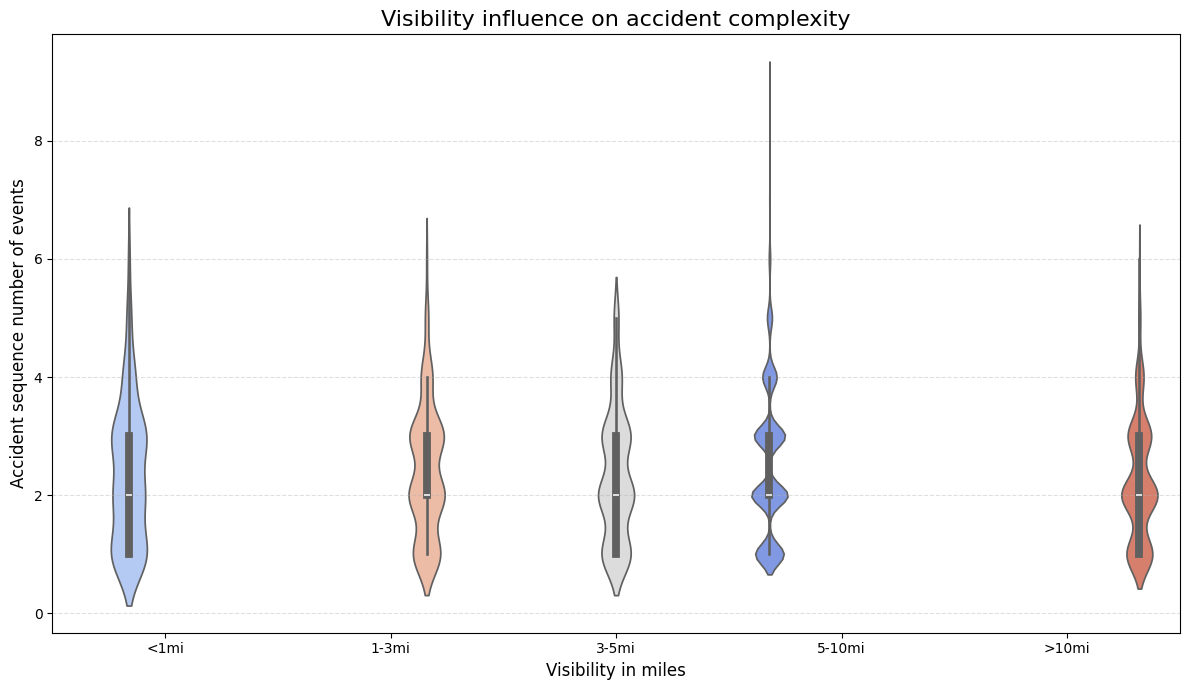

In [12]:
#EDA 7 - visibility's influence on accident complexity

weather_cols = ['vis_sm', 'wind_vel_kts', 'sky_ceil_ht']
for col in weather_cols:
    incidents[col] = pd.to_numeric(incidents[col], errors='coerce')

weather_impact = pd.merge(incidents[incidents['Occurrence_No'] == 1], 
                         sequence_lengths[['ev_id', 'seq_length']], 
                         on='ev_id')

plt.figure(figsize=(12, 7))

weather_impact['vis_category'] = pd.cut(weather_impact['vis_sm'], 
                                       bins=[0, 1, 3, 5, 10, 50], 
                                       labels=['<1mi', '1-3mi', '3-5mi', '5-10mi', '>10mi'])

sns.violinplot(data=weather_impact.dropna(subset=['vis_category']), 
               x='vis_category', y='seq_length', 
               hue='vis_category', palette='coolwarm', legend=False)

plt.title('Visibility influence on accident complexity', fontsize=16)
plt.xlabel('Visibility in miles', fontsize=12)
plt.ylabel('Accident sequence number of events', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

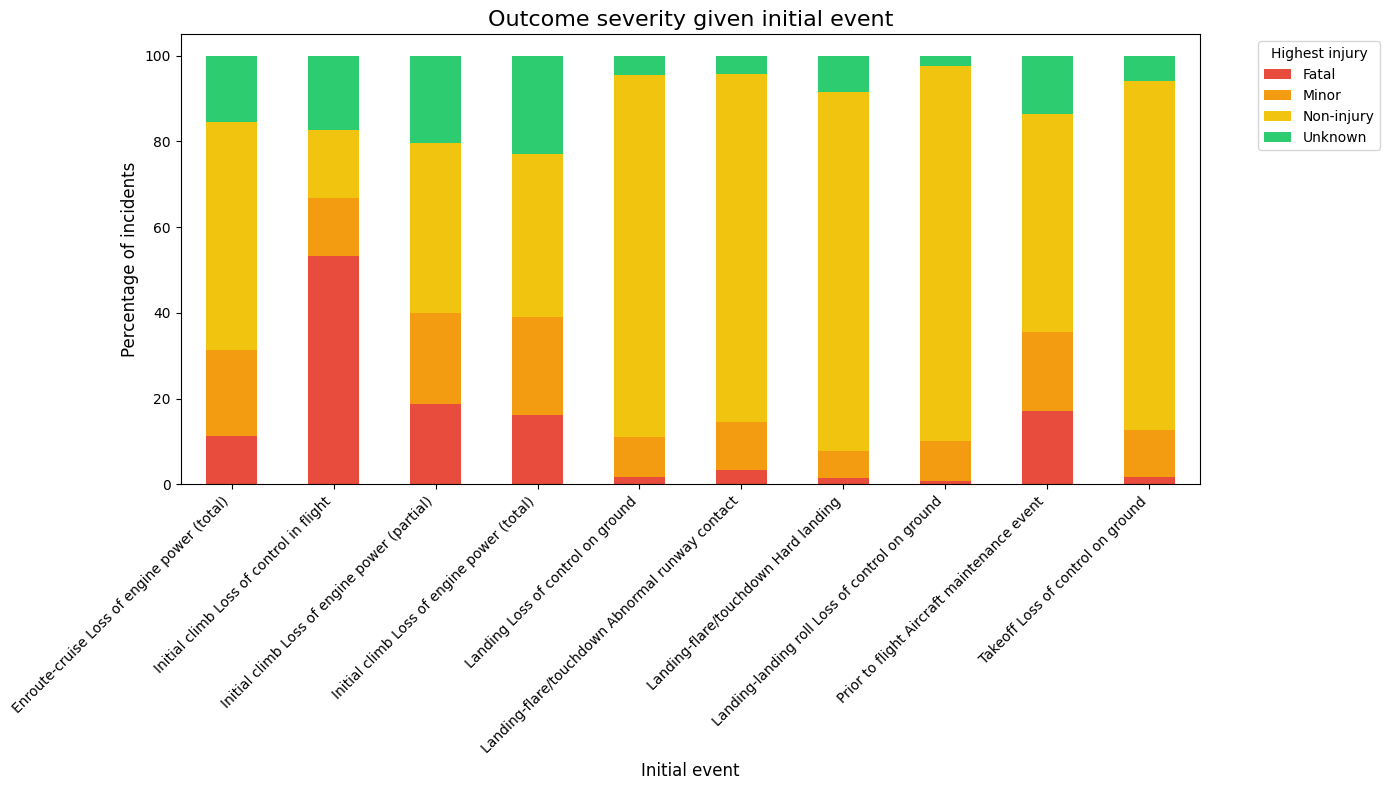

In [13]:
#EDA 8 - severity, outcome analysis

#simplify injury categories, 'FATL', 'NONE', 'SVR', 'MINR' are grouped
severity_map = {
    'FATL': 'Fatal',
    'SVR': 'Serious',
    'MINR': 'Minor',
    'NONE': 'Non-injury'
}
incidents['severity'] = incidents['ev_highest_injury'].map(severity_map).fillna('Unknown')

starting_events = incidents[incidents['Occurrence_No'] == 1].copy()

# 3. filter for top 10 events
top_starts = starting_events['Occurrence_Description'].value_counts().nlargest(10).index
plot_data = starting_events[starting_events['Occurrence_Description'].isin(top_starts)]

plt.figure(figsize=(14, 8))
pivot_data = pd.crosstab(plot_data['Occurrence_Description'], plot_data['severity'], normalize='index') * 100

pivot_data.plot(kind='bar', stacked=True, color=['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71'], ax=plt.gca())

plt.title('Outcome severity given initial event', fontsize=16)
plt.ylabel('Percentage of incidents', fontsize=12)
plt.xlabel('Initial event', fontsize=12)
plt.legend(title='Highest injury', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:

# Model 1 - LSTM

seq_grouped = (
    events_seq
    .groupby(["ev_id", "Aircraft_Key"])["Occurrence_Code"]
    .apply(list)
    .reset_index()
)

seq_grouped["first_two"] = seq_grouped["Occurrence_Code"].apply(lambda x: x[:2])

incident_df = seq_grouped.merge(
    events_clean[["ev_id", "ev_highest_injury"]],
    on="ev_id",
    how="inner"
)

occ_le = LabelEncoder()
all_codes = np.concatenate(incident_df["first_two"].values)
occ_le.fit(all_codes)

incident_df["seq_encoded"] = incident_df["first_two"].apply(
    lambda x: occ_le.transform(x)
)

X = pad_sequences(incident_df["seq_encoded"], maxlen=2, padding="post")

sev_le = LabelEncoder()
y = sev_le.fit_transform(incident_df["ev_highest_injury"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(occ_le.classes_)+1, 64, mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(sev_le.classes_), activation="softmax")
])

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

history = model_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weights_dict
)

y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)

print(classification_report(
    y_test,
    y_pred_lstm,
    target_names=sev_le.classes_
))


Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5116 - loss: 1.2212 - val_accuracy: 0.5376 - val_loss: 1.1053
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5531 - loss: 1.1122 - val_accuracy: 0.5530 - val_loss: 1.0927
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5718 - loss: 1.0735 - val_accuracy: 0.5157 - val_loss: 1.1029
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5700 - loss: 1.0492 - val_accuracy: 0.5152 - val_loss: 1.1134
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5778 - loss: 1.0284 - val_accuracy: 0.5162 - val_loss: 1.1051
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5797 - loss: 1.0102 - val_accuracy: 0.5237 - val_loss: 1.1202
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5826 - loss: 0.9959 - val_accuracy: 0.5067 - val_loss: 1.1275
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5874 - loss: 0.9878 - val_accuracy: 0.

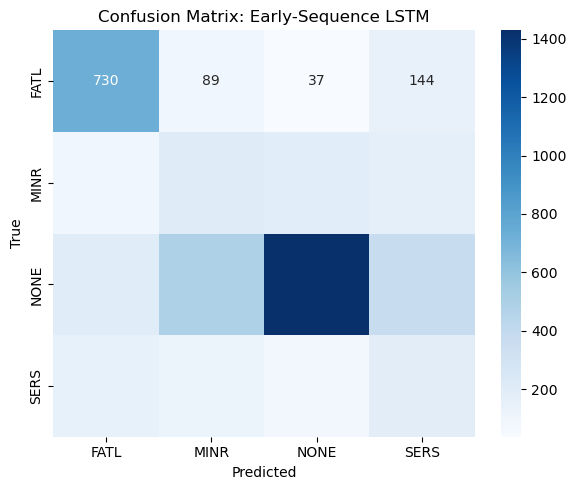

In [10]:
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=sev_le.classes_,
            yticklabels=sev_le.classes_)

plt.title("Confusion Matrix: Early-Sequence LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm.png", dpi=300)
plt.show()


In [ ]:
# Model 2 - xgboost

first_two = events_seq.groupby(
    ['ev_id','Aircraft_Key']
).head(2).copy()

first_two['event_order'] = first_two.groupby(
    ['ev_id','Aircraft_Key']
).cumcount()

wide = first_two.pivot_table(
    index=['ev_id','Aircraft_Key'],
    columns='event_order',
    values='Occurrence_Code',
    aggfunc='first'
).reset_index()

wide.columns = ['ev_id','Aircraft_Key','event_1','event_2']

features_df = wide.merge(
    events_clean[['ev_id',
                  'ev_highest_injury',
                  'ev_month',
                  'light_cond',
                  'wx_cond_basic',
                  'wind_vel_kts',
                  'vis_sm',
                  'mid_air',
                  'on_ground_collision']],
    on='ev_id',
    how='inner'
)

features_df = features_df.fillna(-1)
features_df['ev_highest_injury'] = features_df['ev_highest_injury'].astype(str)

sev_le_xgb = LabelEncoder()
features_df['severity_encoded'] = sev_le_xgb.fit_transform(
    features_df['ev_highest_injury']
)

X = features_df.drop(columns=['ev_id','Aircraft_Key',
                              'ev_highest_injury',
                              'severity_encoded'])
X = pd.get_dummies(X, drop_first=False)
y = features_df['severity_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1021
)

model_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(sev_le_xgb.classes_),
    eval_metric='mlogloss',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1021
)

model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=sev_le_xgb.classes_
))


              precision    recall  f1-score   support

        FATL       0.63      0.69      0.66      1000
        MINR       0.35      0.02      0.03       660
        NONE       0.65      0.92      0.76      2493
        SERS       0.72      0.07      0.13       540

    accuracy                           0.64      4693
   macro avg       0.59      0.42      0.40      4693
weighted avg       0.61      0.64      0.56      4693



In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

results = []

embedding_dims = [32, 64]
lstm_units = [64, 128]
dropouts = [0.2, 0.4]

for emb_dim in embedding_dims:
    for lstm_unit in lstm_units:
        for dr in dropouts:
            
            print(f"\nTraining model: emb={emb_dim}, lstm={lstm_unit}, dropout={dr}")
            
            model = tf.keras.Sequential([
                tf.keras.layers.Embedding(input_dim=len(le.classes_), output_dim=emb_dim),
                tf.keras.layers.LSTM(lstm_unit, dropout=dr, recurrent_dropout=dr),
                tf.keras.layers.Dense(len(le.classes_), activation='softmax')
            ])
            
            model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
            
            history = model.fit(
                X_train,
                y_train,
                epochs=8,
                batch_size=64,
                validation_split=0.2,
                callbacks=[early_stop],
                verbose=0
            )
            
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            
            y_pred = model.predict(X_test, verbose=0)
            top_3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)
            top_3_acc.update_state(y_test, y_pred)
            
            results.append({
                "Embedding_dim": emb_dim,
                "LSTM_units": lstm_unit,
                "Dropout": dr,
                "Test_Accuracy": accuracy,
                "Top3_Accuracy": top_3_acc.result().numpy()
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Test_Accuracy", ascending=False)

results_df



Training model: emb=32, lstm=64, dropout=0.2

Training model: emb=32, lstm=64, dropout=0.4

Training model: emb=32, lstm=128, dropout=0.2

Training model: emb=32, lstm=128, dropout=0.4

Training model: emb=64, lstm=64, dropout=0.2

Training model: emb=64, lstm=64, dropout=0.4

Training model: emb=64, lstm=128, dropout=0.2

Training model: emb=64, lstm=128, dropout=0.4


,Embedding_dim,LSTM_units,Dropout,Test_Accuracy,Top3_Accuracy
6,64,128,0.2,0.294480,0.485661
7,64,128,0.4,0.292630,0.477027
2,32,128,0.2,0.280913,0.474561
3,32,128,0.4,0.273204,0.459451
5,64,64,0.4,0.245760,0.431391
4,64,64,0.2,0.245143,0.416898
0,32,64,0.2,0.232192,0.403639
1,32,64,0.4,0.227567,0.393771


In [17]:
most_common_class = incidents['event_code_encoded'].value_counts().idxmax()
baseline_acc = np.mean(y_test == most_common_class)
print("Baseline accuracy:", baseline_acc)

Baseline accuracy: 0.13290163428923835


--- Back-off Model Results (Max Order 4) ---
Overall Accuracy: 0.2572

Prediction Source Breakdown:
Order global: 4 predictions
Order 4: 30 predictions
Order 3: 63 predictions
Order 2: 146 predictions
Order 1: 103 predictions


         Order Backoff_Accuracy Single_Order_Accuracy
0            1              N/A              0.301832
1            2              N/A              0.264854
2            3              N/A              0.193694
3            4              N/A              0.089595
4  1 through 4         0.257225                   N/A


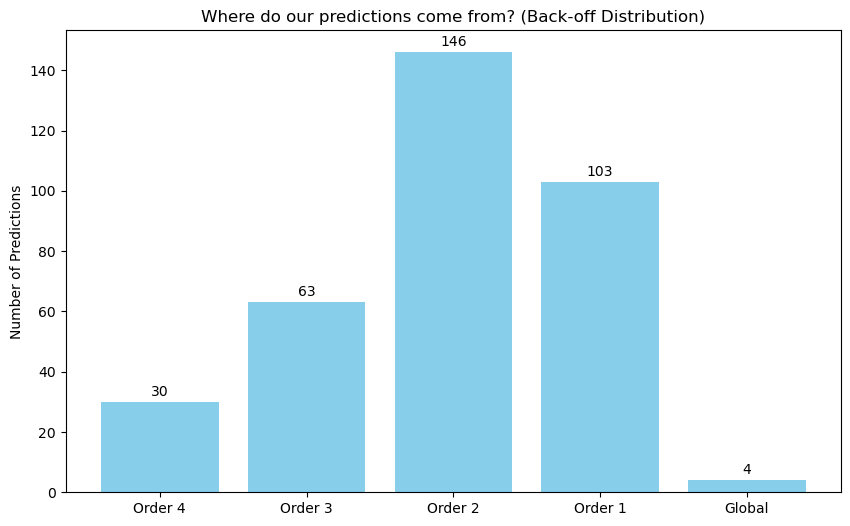

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

sequences = incidents.groupby(['ev_id', 'Aircraft_Key'])['event_code_encoded'].apply(list).values
sequences = [seq for seq in sequences if len(seq) > 1]

train_seqs, test_seqs = train_test_split(sequences, test_size=0.2, random_state=1021)

global_counts = Counter([event for seq in train_seqs for event in seq])
global_most_common = global_counts.most_common(1)[0][0]

def build_markov_model(seqs, order=1, smoothing=0):
    transitions = defaultdict(Counter)
    for seq in seqs:
        for i in range(len(seq) - order):
            context = tuple(seq[i:i+order])
            next_event = seq[i+order]
            transitions[context][next_event] += 1
    
    model = {}
    vocab_size = len(global_counts)
    for context, counter in transitions.items():
        total = sum(counter.values())
        probs = {event: (count + smoothing) / (total + smoothing * vocab_size) 
                 for event, count in counter.items()}
        model[context] = max(probs, key=probs.get)
    return model

def evaluate_backoff_model(models_dict, seqs, max_order):
    correct = 0
    total = 0
    usage_stats = Counter()

    for seq in seqs:
        for i in range(len(seq) - max_order):
            true_next = seq[i + max_order]
            prediction = None
            
            for current_order in range(max_order, 0, -1):
                if current_order in models_dict:
                    context = tuple(seq[i + (max_order - current_order) : i + max_order])
                    
                    if context in models_dict[current_order]:
                        prediction = models_dict[current_order][context]
                        usage_stats[current_order] += 1
                        break
            
            if prediction is None:
                prediction = global_most_common
                usage_stats['global'] += 1
                
            if prediction == true_next:
                correct += 1
            total += 1
            
    accuracy = correct / total if total > 0 else 0
    return accuracy, usage_stats

max_target_order = 4
all_models = {o: build_markov_model(train_seqs, order=o, smoothing=0) 
              for o in range(1, max_target_order + 1)}

backoff_acc, stats = evaluate_backoff_model(all_models, test_seqs, max_order=max_target_order)

print(f"--- Back-off Model Results (Max Order {max_target_order}) ---")
print(f"Overall Accuracy: {backoff_acc:.4f}")
print("\nPrediction Source Breakdown:")
for source, count in sorted(stats.items(), key=lambda x: str(x[0]), reverse=True):
    print(f"Order {source}: {count} predictions")

comparison_results = []
for o in range(1, max_target_order + 1):
    single_acc, _ = evaluate_backoff_model({o: all_models[o]}, test_seqs, max_order=o)
    comparison_results.append({"Order": o, "Backoff_Accuracy": "N/A", "Single_Order_Accuracy": single_acc})

comparison_results.append({"Order": f"1 through {max_target_order}", "Backoff_Accuracy": backoff_acc, "Single_Order_Accuracy": "N/A"})

results_df = pd.DataFrame(comparison_results)
print("\n")
print(results_df)

#visualising improvement too:

import matplotlib.pyplot as plt

labels = [f'Order {i}' for i in range(4, 0, -1)] + ['Global']
counts = [stats[4], stats[3], stats[2], stats[1], stats['global']]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color='skyblue')
plt.title('Where do our predictions come from? (Back-off Distribution)')
plt.ylabel('Number of Predictions')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

def decode_event(code_int):
    return le.inverse_transform([int(code_int)])[0]

def make_ngrams(seq, n):
    if len(seq) < n:
        return []
    return [tuple(seq[i:i+n]) for i in range(len(seq) - n + 1)]

def ngram_counts_from_sequences(sequences, n, min_seq_len=2):
    c = Counter()
    for seq in sequences:
        if seq is None:
            continue
        if len(seq) < min_seq_len:
            continue
        c.update(make_ngrams(seq, n))
    return c

def context_target_counts(ngram_counter):
    ctx_to_next = defaultdict(Counter)
    for ngram, ct in ngram_counter.items():
        ctx = ngram[:-1]
        nxt = ngram[-1]
        ctx_to_next[ctx][nxt] += ct
    return ctx_to_next

def summarize_ngram_model(sequences, n, top_k=15, min_transition_count=1):
    ngram_ct = ngram_counts_from_sequences(sequences, n)
    
    if min_transition_count > 1:
        ngram_ct = Counter({k:v for k,v in ngram_ct.items() if v >= min_transition_count})
    
    total_ngrams = sum(ngram_ct.values())
    unique_ngrams = len(ngram_ct)
    
    ctx_to_next = context_target_counts(ngram_ct)
    unique_contexts = len(ctx_to_next)
    
    ctx_freq = {ctx: sum(next_ct.values()) for ctx, next_ct in ctx_to_next.items()}
    ctx_freq_sorted = sorted(ctx_freq.items(), key=lambda x: x[1], reverse=True)

    top_ctx_coverage = []
    running = 0
    for i, (ctx, ct) in enumerate(ctx_freq_sorted, start=1):
        running += ct
        if i in [1, 5, 10, 20, 50, 100]:
            top_ctx_coverage.append((i, running / total_ngrams if total_ngrams else np.nan))
    
    ctx_maxprob = []
    for ctx, next_ct in ctx_to_next.items():
        denom = sum(next_ct.values())
        maxprob = max(next_ct.values()) / denom
        ctx_maxprob.append(maxprob)
    ctx_maxprob = np.array(ctx_maxprob) if len(ctx_maxprob) else np.array([])
    
    top_transitions = ngram_ct.most_common(top_k)
    
    rows = []
    for ngram, ct in top_transitions:
        ctx = ngram[:-1]
        nxt = ngram[-1]
        denom = sum(ctx_to_next[ctx].values())
        p = ct / denom if denom else np.nan
        
        ctx_decoded = " | ".join([str(decode_event(x)) for x in ctx])
        nxt_decoded = str(decode_event(nxt))
        
        rows.append({
            "order": n-1,
            "context_len": n-1,
            "context": ctx_decoded,
            "next_event": nxt_decoded,
            "count": ct,
            "P(next | context)": p
        })
    top_df = pd.DataFrame(rows)
    
    summary = {
        "n": n,
        "order": n-1,
        "min_transition_count": min_transition_count,
        "total_transitions_counted": total_ngrams,
        "unique_ngrams": unique_ngrams,
        "unique_contexts": unique_contexts,
        "top_context_coverage": top_ctx_coverage,
        "ctx_maxprob_quantiles": (
            np.quantile(ctx_maxprob, [0.5, 0.75, 0.9, 0.95]).tolist()
            if len(ctx_maxprob) else [np.nan]*4
        )
    }
    return summary, top_df, ctx_freq_sorted

best_summary, best_top_df, best_ctx_freq_sorted = summarize_ngram_model(
    sequences=sequences,
    n=4,                 
    top_k=15,
    min_transition_count=1
)

print("=== Order 3 (best) transition summary ===")
for k, v in best_summary.items():
    print(f"{k}: {v}")

print("\nTop transitions (order 3):")
display(best_top_df)

print("\nContext coverage (fraction of all transitions explained by top contexts):")
for k, frac in best_summary["top_context_coverage"]:
    print(f"Top {k:>3} contexts cover {frac*100:.2f}% of transitions")

print("\nHow deterministic are contexts?  (median/75%/90%/95% of max P(next|context))")
q50, q75, q90, q95 = best_summary["ctx_maxprob_quantiles"]
print(f"Median={q50:.3f}, 75%={q75:.3f}, 90%={q90:.3f}, 95%={q95:.3f}")

summaries = []
for n in [2,3,4,5]:
    s, _, _ = summarize_ngram_model(sequences, n=n, top_k=5, min_transition_count=1)
    summaries.append(s)

comparison_df = pd.DataFrame([{
    "Order": s["order"],
    "Total transitions counted": s["total_transitions_counted"],
    "Unique contexts": s["unique_contexts"],
    "Unique ngrams": s["unique_ngrams"],
    "Median max P(next|context)": s["ctx_maxprob_quantiles"][0],
    "90% max P(next|context)": s["ctx_maxprob_quantiles"][2]
} for s in summaries])

print("\n=== Order comparison summary ===")
display(comparison_df)

best_summary_5, best_top_df_5, _ = summarize_ngram_model(
    sequences=sequences,
    n=4,
    top_k=15,
    min_transition_count=5
)

print("\n=== Order 3 summary with min_transition_count=5 (analysis only) ===")
for k, v in best_summary_5.items():
    print(f"{k}: {v}")

print("\nTop transitions (order 3) after filtering <5:")
display(best_top_df_5)

=== Order 3 (best) transition summary ===
n: 4
order: 3
min_transition_count: 1
total_transitions_counted: 5242
unique_ngrams: 4562
unique_contexts: 3996
top_context_coverage: [(1, 0.00877527661198016), (5, 0.03681800839374284), (10, 0.05742083174360931), (20, 0.08813429988553988), (50, 0.1333460511255246), (100, 0.17512399847386495)]
ctx_maxprob_quantiles: [1.0, 1.0, 1.0, 1.0]

Top transitions (order 3):


,order,context_len,context,next_event,count,P(next | context)
0,3,3,552230 | 552060 | 552300,552470,29,0.690476
1,3,3,552230 | 552300 | 552470,552096,25,0.543478
2,3,3,550230 | 550060 | 550300,550470,24,0.558140
3,3,3,552400 | 552230 | 552300,552470,18,0.562500
4,3,3,300230 | 300060 | 300300,300470,17,0.566667
5,3,3,552230 | 552300 | 552470,552094,14,0.304348
6,3,3,551090 | 552230 | 552300,552470,13,0.590909
7,3,3,552330 | 552230 | 552300,552470,12,0.631579
8,3,3,550400 | 550230 | 550300,550470,12,0.631579
9,3,3,552230 | 552060 | 552300,552096,10,0.238095



Context coverage (fraction of all transitions explained by top contexts):
Top   1 contexts cover 0.88% of transitions
Top   5 contexts cover 3.68% of transitions
Top  10 contexts cover 5.74% of transitions
Top  20 contexts cover 8.81% of transitions
Top  50 contexts cover 13.33% of transitions
Top 100 contexts cover 17.51% of transitions

How deterministic are contexts?  (median/75%/90%/95% of max P(next|context))
Median=1.000, 75%=1.000, 90%=1.000, 95%=1.000

=== Order comparison summary ===


,Order,Total transitions counted,Unique contexts,Unique ngrams,Median max P(next|context),90% max P(next|context)
0,1,30803,1260,9939,0.5,1.0
1,2,14588,5868,9567,1.0,1.0
2,3,5242,3996,4562,1.0,1.0
3,4,1554,1463,1519,1.0,1.0



=== Order 3 summary with min_transition_count=5 (analysis only) ===
n: 4
order: 3
min_transition_count: 5
total_transitions_counted: 410
unique_ngrams: 46
unique_contexts: 36
top_context_coverage: [(1, 0.0951219512195122), (5, 0.4170731707317073), (10, 0.5902439024390244), (20, 0.7951219512195122)]
ctx_maxprob_quantiles: [1.0, 1.0, 1.0, 1.0]

Top transitions (order 3) after filtering <5:


,order,context_len,context,next_event,count,P(next | context)
0,3,3,552230 | 552060 | 552300,552470,29,0.743590
1,3,3,552230 | 552300 | 552470,552096,25,0.641026
2,3,3,550230 | 550060 | 550300,550470,24,0.615385
3,3,3,552400 | 552230 | 552300,552470,18,0.642857
4,3,3,300230 | 300060 | 300300,300470,17,0.653846
5,3,3,552230 | 552300 | 552470,552094,14,0.358974
6,3,3,551090 | 552230 | 552300,552470,13,1.000000
7,3,3,552330 | 552230 | 552300,552470,12,1.000000
8,3,3,550400 | 550230 | 550300,550470,12,1.000000
9,3,3,552230 | 552060 | 552300,552096,10,0.256410


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

# building a further and more refined Markov model

sequences = incidents.groupby(['ev_id', 'Aircraft_Key'])['event_code_encoded'].apply(list).values
sequences = [seq for seq in sequences if len(seq) > 1]

train_seqs, test_seqs = train_test_split(sequences, test_size=0.2, random_state=1021)

global_counts = Counter([event for seq in train_seqs for event in seq])
global_most_common = global_counts.most_common(1)[0][0]


def build_markov_model(seqs, order=1, smoothing=0):
    transitions = defaultdict(Counter)
    
    for seq in seqs:
        for i in range(len(seq) - order):
            context = tuple(seq[i:i+order])
            next_event = seq[i+order]
            transitions[context][next_event] += 1
    
    model = {}
    for context, counter in transitions.items():
        total = sum(counter.values())
        vocab_size = len(global_counts)
        
        probs = {}
        for event in global_counts.keys():
            count = counter[event]
            probs[event] = (count + smoothing) / (total + smoothing * vocab_size)
        
        model[context] = probs
    
    return model

def evaluate_markov(model, seqs, order=1, fallback="none"):
    correct = 0
    total = 0
    
    for seq in seqs:
        for i in range(len(seq) - order):
            context = tuple(seq[i:i+order])
            true_next = seq[i+order]
            
            if context in model:
                probs = model[context]
                pred = max(probs, key=probs.get)
            else:
                if fallback == "global":
                    pred = global_most_common
                else:
                    continue  
            
            if pred == true_next:
                correct += 1
            total += 1
    
    return correct / total if total > 0 else 0

orders = [1, 2, 3, 4]
smoothing_vals = [0, 1]
fallback_modes = ["none", "global"]

results = []

for order in orders:
    for smoothing in smoothing_vals:
        for fallback in fallback_modes:
            
            model = build_markov_model(train_seqs, order=order, smoothing=smoothing)
            acc = evaluate_markov(model, test_seqs, order=order, fallback=fallback)
            
            results.append({
                "Order": order,
                "Smoothing": smoothing,
                "Fallback": fallback,
                "Accuracy": acc
            })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

results_df

,Order,Smoothing,Fallback,Accuracy
8,3,0,none,0.433526
10,3,1,none,0.433526
4,2,0,none,0.350674
6,2,1,none,0.350674
12,4,0,none,0.333333
14,4,1,none,0.333333
0,1,0,none,0.310261
2,1,1,none,0.310261
1,1,0,global,0.306654
3,1,1,global,0.306654


In [ ]:
ngram_counts_order3 = ngram_counts_from_sequences(sequences, n=4)

ctx_to_next_order3 = context_target_counts(ngram_counts_order3)

def check_determinism(ctx_to_next):
    max_probs = []
    for ctx, next_events in ctx_to_next.items():
        total = sum(next_events.values())
        highest_freq = max(next_events.values())
        max_probs.append(highest_freq / total)
    
    return np.quantile(max_probs, [0.5, 0.75, 0.9])

quantiles = check_determinism(ctx_to_next_order3)
print(f"Median Context Determinism: {quantiles[0]}")

Median Context Determinism: 1.0


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_features = ['light_cond', 'sky_cond_ceil', 'wx_cond_basic', 'ev_type', 'ev_dow']
num_features = ['ev_month', 'ev_hour', 'vis_sm', 'wind_vel_kts', 'wx_temp', 'apt_elev']

meta_cols = cat_features + num_features
metadata_df = incidents.groupby(['ev_id', 'Aircraft_Key'])[meta_cols].first().reset_index()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

meta_features = preprocessor.fit_transform(metadata_df)

print(f"Expanded Metadata Shape: {meta_features.shape}")
meta_dim = meta_features.shape[1]

Expanded Metadata Shape: (24312, 33)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

seq_data = incidents.groupby(['ev_id', 'Aircraft_Key'])['event_code_encoded'].apply(list).values

valid_indices = [i for i, s in enumerate(seq_data) if len(s) > 1]

X_raw = [s[:-1] for s in seq_data if len(s) > 1]
y_raw = [s[-1] for s in seq_data if len(s) > 1]

meta_features_aligned = meta_features[valid_indices]

max_length = 10 
X_padded = pad_sequences(X_raw, maxlen=max_length, padding='pre')
y_raw = np.array(y_raw)

X_train_seq, X_test_seq, y_train, y_test = train_test_split(
    X_padded, y_raw, test_size=0.2, random_state=1021
)

meta_train, meta_test = train_test_split(
    meta_features_aligned, test_size=0.2, random_state=1021
)

meta_dim = meta_train.shape[1]

print(f"X_train_seq shape: {X_train_seq.shape}") 
print(f"meta_train shape:   {meta_train.shape}")   
print(f"y_train shape:      {y_train.shape}")         
print(f"Model will accept {meta_dim} contextual features.")

# hybrid model architecture
seq_input = Input(shape=(max_length,), name="Sequence_Input")
x_seq = Embedding(input_dim=len(le.classes_), output_dim=64)(seq_input)
x_seq = LSTM(128, return_sequences=False)(x_seq)
x_seq = Dropout(0.3)(x_seq)

meta_input = Input(shape=(meta_dim,), name="Metadata_Input")
x_meta = Dense(128, activation='relu')(meta_input)
x_meta = Dropout(0.2)(x_meta)
x_meta = Dense(64, activation='relu')(x_meta)

merged = Concatenate()([x_seq, x_meta])

z = Dense(64, activation='relu')(merged)
z = Dropout(0.2)(z)
output = Dense(len(le.classes_), activation='softmax')(z)

hybrid_model = Model(inputs=[seq_input, meta_input], outputs=output)
hybrid_model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=0.00001
)


history = hybrid_model.fit(
    x=[X_train_seq, meta_train], 
    y=y_train, 
    validation_data=([X_test_seq, meta_test], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

X_train_seq shape: (12972, 10)
meta_train shape:   (12972, 33)
y_train shape:      (12972,)
Model will accept 33 contextual features.
Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.1211 - loss: 4.9282 - val_accuracy: 0.1329 - val_loss: 4.4476 - learning_rate: 0.0010
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.1699 - loss: 4.3676 - val_accuracy: 0.1943 - val_loss: 4.1653 - learning_rate: 0.0010
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.2116 - loss: 4.0372 - val_accuracy: 0.2208 - val_loss: 3.9225 - learning_rate: 0.0010
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.2357 - loss: 3.8379 - val_accuracy: 0.2621 - val_loss: 3.8086 - learning_rate: 0.0010
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.2481 - loss: 3.7110 - val_accuracy: 0.2664 - val_loss: 3.7500 - learning_rate: 0.0010
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.2536 - loss: 3.6188 - val_accurac

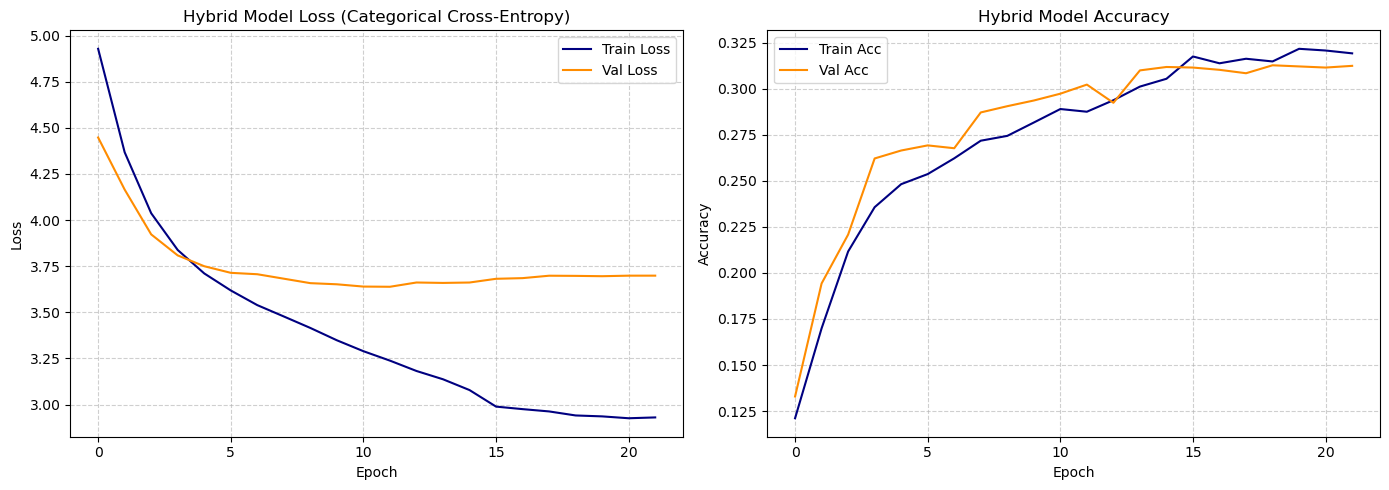

In [ ]:
import matplotlib.pyplot as plt

def plot_hybrid_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['loss'], label='Train Loss', color='navy')
    ax1.plot(history.history['val_loss'], label='Val Loss', color='darkorange')
    ax1.set_title('Hybrid Model Loss (Categorical Cross-Entropy)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    ax2.plot(history.history['accuracy'], label='Train Acc', color='navy')
    ax2.plot(history.history['val_accuracy'], label='Val Acc', color='darkorange')
    ax2.set_title('Hybrid Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_hybrid_results(history)

Average sequence length: 2.27
Median sequence length:  2.0
Max sequence length:     9
95th percentile:         4.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


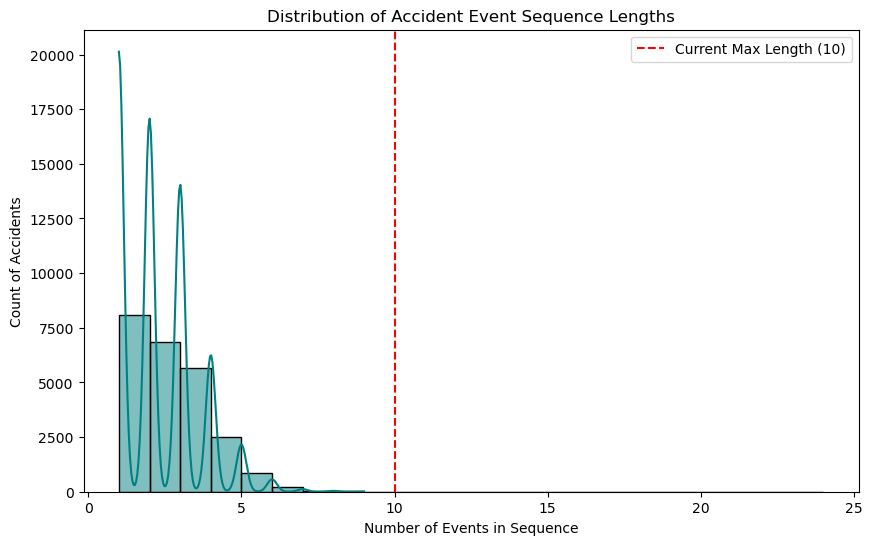

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sequence_lengths = [len(s) for s in seq_data]

print(f"Average sequence length: {np.mean(sequence_lengths):.2f}")
print(f"Median sequence length:  {np.median(sequence_lengths)}")
print(f"Max sequence length:     {np.max(sequence_lengths)}")
print(f"95th percentile:         {np.percentile(sequence_lengths, 95)}")

plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=range(1, 25), kde=True, color='teal')
plt.axvline(10, color='red', linestyle='--', label='Current Max Length (10)')
plt.title('Distribution of Accident Event Sequence Lengths')
plt.xlabel('Number of Events in Sequence')
plt.ylabel('Count of Accidents')
plt.legend()
plt.show()

Epoch 1/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1219 - loss: 5.4171 - val_accuracy: 0.1446 - val_loss: 4.9739 - learning_rate: 0.0010
Epoch 2/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2071 - loss: 4.7061 - val_accuracy: 0.2433 - val_loss: 4.4342 - learning_rate: 0.0010
Epoch 3/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.2758 - loss: 4.2836 - val_accuracy: 0.2899 - val_loss: 4.1930 - learning_rate: 0.0010
Epoch 4/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.2910 - loss: 4.0788 - val_accuracy: 0.3025 - val_loss: 4.1114 - learning_rate: 0.0010
Epoch 5/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3065 - loss: 3.9634 - val_accuracy: 0.3145 - val_loss: 4.0771 - learning_rate: 0.0010
Epoch 6/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3144 - loss: 3.8758 - val_accuracy: 0.3296 - val_loss: 4.0470 - learning_rate: 0.0010
Epoch 7/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3254 - loss: 3

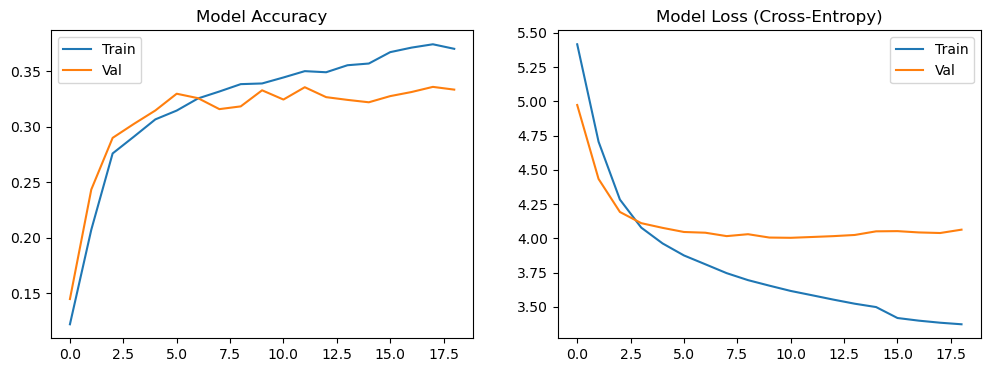

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Concatenate, MultiHeadAttention, 
    LayerNormalization, GlobalAveragePooling1D, Dense, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

if 'ev_index' not in incidents.columns:
    incidents['ev_index'] = incidents.groupby(['ev_id', 'Aircraft_Key']).cumcount()

incidents['ev_time'] = pd.to_datetime(incidents['ev_time'])
incidents = incidents.sort_values(['ev_id', 'Aircraft_Key', 'ev_index'])

incidents['density_alt'] = incidents['apt_elev'] + (120 * (incidents['wx_temp'] - 15))
incidents['wind_vis_ratio'] = incidents['wind_vel_kts'] / (incidents['vis_sm'] + 0.1)
incidents['situation_cross'] = incidents['light_cond'].astype(str) + "_" + incidents['ev_type'].astype(str)
incidents['hour_sin'] = np.sin(2 * np.pi * incidents['ev_hour'] / 24)
incidents['hour_cos'] = np.cos(2 * np.pi * incidents['ev_hour'] / 24)

incidents['time_diff'] = incidents.groupby(['ev_id', 'Aircraft_Key'])['ev_time'].diff().dt.total_seconds() / 60.0
incidents['time_diff'] = np.log1p(incidents['time_diff'].fillna(0)) # Log-scale immediately

cat_features = ['light_cond', 'sky_cond_ceil', 'wx_cond_basic', 'ev_type', 'ev_dow', 'situation_cross']
num_features = ['ev_month', 'vis_sm', 'wind_vel_kts', 'wx_temp', 'apt_elev', 'density_alt', 'wind_vis_ratio', 'hour_sin', 'hour_cos']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('scal', StandardScaler())]), num_features),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='constant', fill_value='UNK')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_features)
])

metadata_df = incidents.groupby(['ev_id', 'Aircraft_Key'])[cat_features + num_features].first().reset_index()
meta_features = preprocessor.fit_transform(metadata_df)

grouped = incidents.groupby(['ev_id', 'Aircraft_Key'])
X_seq_raw = [s[:-1] for s in grouped['event_code_encoded'].apply(list) if len(s) > 1]
X_time_raw = [s[:-1] for s in grouped['time_diff'].apply(list) if len(s) > 1]
y_raw = np.array([s[-1] for s in grouped['event_code_encoded'].apply(list) if len(s) > 1])

valid_mask = [len(s) > 1 for s in grouped['event_code_encoded'].apply(list)]
meta_features_aligned = meta_features[valid_mask]

max_length = 5
X_padded_seq = pad_sequences(X_seq_raw, maxlen=max_length, padding='pre')
X_padded_time = pad_sequences(X_time_raw, maxlen=max_length, dtype='float32', padding='pre')
X_padded_time = np.expand_dims(X_padded_time, axis=-1)

indices = np.arange(len(y_raw))
tr_idx, ts_idx = train_test_split(indices, test_size=0.2, random_state=1021)

X_train_seq, X_test_seq = X_padded_seq[tr_idx], X_padded_seq[ts_idx]
X_train_time, X_test_time = X_padded_time[tr_idx], X_padded_time[ts_idx]
meta_train, meta_test = meta_features_aligned[tr_idx], meta_features_aligned[ts_idx]
y_train, y_test = y_raw[tr_idx], y_raw[ts_idx]

num_classes = len(le.classes_)
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)

meta_dim = meta_train.shape[1]
num_classes = len(le.classes_)
reg_val = 0.001 

seq_in = Input(shape=(max_length,), name="Sequence_Input")
time_in = Input(shape=(max_length, 1), name="Time_Delta_Input")
x_seq = Embedding(num_classes, 32)(seq_in)
x_seq = Concatenate()([x_seq, time_in])
x_seq = MultiHeadAttention(num_heads=2, key_dim=32)(x_seq, x_seq)
x_seq = LayerNormalization()(x_seq)
x_seq = GlobalAveragePooling1D()(x_seq)

meta_in = Input(shape=(meta_dim,), name="Metadata_Input")
x_m = Dense(128, activation='relu', kernel_regularizer=l2(reg_val))(meta_in)
x_m = Dropout(0.3)(x_m)

merged = Concatenate()([x_seq, x_m])
z = Dense(256, activation='relu', kernel_regularizer=l2(reg_val))(merged)
z = Dropout(0.4)(z) 
z = Dense(64, activation='relu')(z) 
out = Dense(num_classes, activation='softmax')(z)

attention_model = Model(inputs=[seq_in, time_in, meta_in], outputs=out)

attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]

history = attention_model.fit(
    x={"Sequence_Input": X_train_seq, "Time_Delta_Input": X_train_time, "Metadata_Input": meta_train},
    y=y_train_oh, 
    validation_data=(
        {"Sequence_Input": X_test_seq, "Time_Delta_Input": X_test_time, "Metadata_Input": meta_test},
        y_test_oh 
    ),
    epochs=60,
    batch_size=64,
    callbacks=callbacks
)

import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('Model Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('Model Loss (Cross-Entropy)')
    ax2.legend()
    plt.show()

plot_history(history)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np


unique_indices = np.unique(y_true)
present_names = [le.classes_[i] for i in unique_indices]

print(classification_report(y_true, y_pred, labels=unique_indices, target_names=present_names))

              precision    recall  f1-score   support

      100010       0.00      0.00      0.00         1
      100020       0.00      0.00      0.00         1
      100030       0.00      0.00      0.00         1
      100040       0.00      0.00      0.00         5
      100050       0.00      0.00      0.00         4
      100193       0.00      0.00      0.00         1
      100900       0.00      0.00      0.00         3
      150230       0.00      0.00      0.00         1
      150330       0.00      0.00      0.00         1
      150460       0.00      0.00      0.00         1
      151030       0.00      0.00      0.00         1
      151200       0.00      0.00      0.00         1
      152060       0.00      0.00      0.00         1
      152081       0.00      0.00      0.00         1
      152200       0.29      0.67      0.40         3
      152230       0.00      0.00      0.00         1
      152338       0.00      0.00      0.00         1
      152900       0.00    

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
